# Stock Prediction using Stocker

Stocker ("stock explorer") is a Python-based toolkit for stock analysis and prediction. It is built on the quandl library for financial data, the prophet library from Facebook for additive models, numpy and pandas for data manipulation, and matplotlib for visualization. 

This notebook will document some of the basic capabilities of Stocker for prediction. First, have to recommend against playing the stock market on a daily basis, with or without Stocker! Mostly I made this tool to gain more experience with time series analysis and object-oriented programming. To see the code for Stocker, check out stocker.py and to see a notebook with analysis examples, look at the [Stocker Analysis Usage notebook](https://github.com/WillKoehrsen/Data-Analysis/blob/master/stocker/Stocker%20Analysis%20Usage.ipynb). 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Matplotlib for plotting in the notebook
import matplotlib.pyplot as plt

%matplotlib inline

## Import the Stocker Class

In [39]:
from stocker import Stocker

### Instantiate a Stocker object 

We will be looking at Amazon stock data throughout this example. To retrieve the data, we simply need to pass the ticker to the stocker class and assign it to a variable. 

In [40]:
amazon = Stocker('AMZN')

AMZN Stocker Initialized. Data covers 1997-05-16 to 2018-01-18.



Prediction Range: 2017-01-18 to 2018-01-18.

Predicted price on 2018-01-17 = $814.77.
Actual price on    2018-01-17 = $1295.00.

Average Absolute Error on Training Data = $18.21.
Average Absolute Error on Testing  Data = $183.86.

When the model predicted an increase, the price increased 57.66% of the time.
When the model predicted a  decrease, the price decreased  44.64% of the time.

The actual value was within the 80% confidence interval 18.80% of the time.


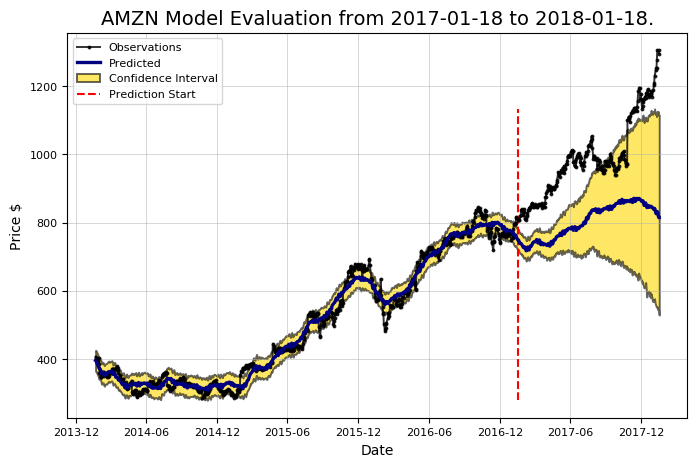

In [29]:
amazon.evaluate_prediction()

You played the stock market in AMZN from 2017-01-18 to 2018-01-18 with 1000 shares.

When the model predicted an increase, the price increased 57.66% of the time.
When the model predicted a  decrease, the price decreased  44.64% of the time.

The total profit using the Prophet model = $305910.00.
The Buy and Hold strategy profit =         $487520.00.

Thanks for playing the stock market!



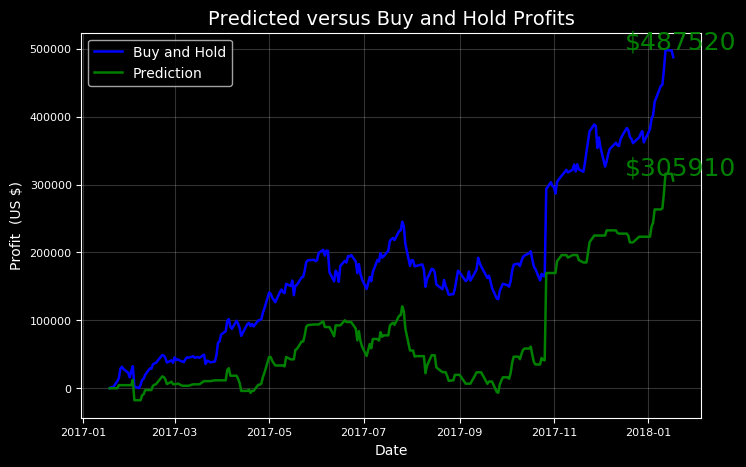

In [30]:
amazon.evaluate_prediction(nshares=1000)

The Stocker object has a number of attributes and methods we can use for analysis and prediction. The main ones we will use in this notebook are `Stocker.create_prophet_model, Stocker.changepoint_prior_analysis, Stocker.changepoint_prior_validation, Stocker.evaluate_prediction,` and `Stocker.predict_future`.

### Basic Plot of Stock History

We have a little over 20 years of Amazon price history. Let's see what that looks like in its entirety.

In [ ]:
amazon.plot_stock()

### Plot of Daily Changes

In [ ]:
amazon.plot_stock(stats=['Daily Change'])

There have been some extreme changes recently although the price has also been increasing, so these changes are roughly the same in magnitude. We could change the plot to have percentage change from the average on the y-axis. There do not appear to be any trends with regards to the changes in one direction or the other over the history of Amazon. However, we know the stock has increased in value, so the overall average daily change must be slightly positive. 

## Create Model to Examine Trends

We can create a basic model (with no predictions) trained on the past 3 years of data to inspect any trends and patterns in the data. 

In [ ]:
model, model_data = amazon.create_prophet_model()

In [ ]:
model.plot_components(model_data)
plt.show()

### Test a Weekly Component

Although it is unlikely, perhaps there is a significant weekly component that including would improve the model. Let's add it in and look at the pattern. 

In [ ]:
amazon.weekly_seasonality=True
model, model_data = amazon.create_prophet_model()

In [ ]:
model.plot_components(model_data)

Maybe there is a slight weekly pattern? For now, we can remove that seasonality and then evaluate models with and without it to see the effect on predictions.

In [ ]:
amazon.weekly_seasonality=False

# First Predictions

Let's quickly make a model for predicting the stock price for the next 3 months. 

In [ ]:
model, model_data = amazon.create_prophet_model(days=90)

# Evaluate Model

Anyone can make stock predictions by simply picking a number and calling that an estimate. For our predictions to be meaningful, we must evaluate them on real data. 

One way to do this is set aside some historical data as a test set and use data from further back as our training set. In the default evaluation method, we test using the past year and train on the 3 years prior to the test period. 

To put our predictions in perspective, we can find the average dollar error, the average range of uncertainty, the average time the price was in the uncertainty range, and the average number of times we predicted the correct direction. 

In [16]:
amazon.evaluate_prediction()

NameError: name 'text' is not defined

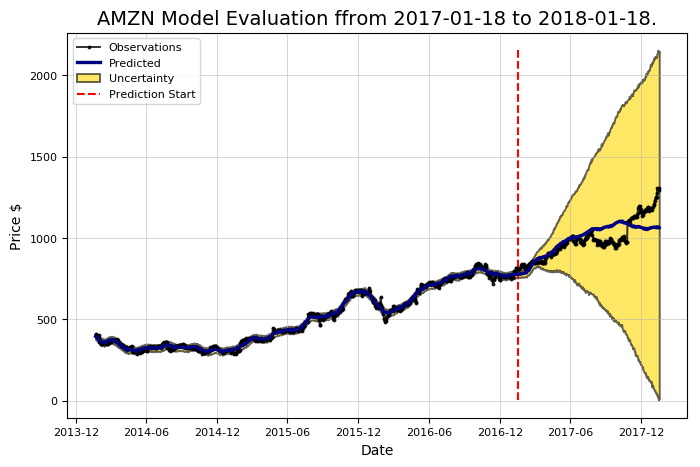

In [7]:
amazon.changepoint_prior_scale=0.2
amazon.evaluate_prediction()

## Play the Daily Market

For fun (this should never be done for real) we can "play" the market with our predictions. We will compare our model with the simple strategy of buying and holding over the same time period. The rules of our game are straightforward:

1. If we predict the price will increase, we buy stock on that day. If we predict a decrease, we do not play the market.
2. If we predicted an increase and the stock does increase, we recieve the change in price of the stock over that day times the number of shares.
3. If we predicted an increase and the stock decreases, we lose the change in price of the stock over that day times the number of shares.

We are assuming the "change in price of a share on that day" is the difference between the previous days' closing price and the closing price on our day. For example, if the closing price on Monday was \$14 and the closing price on Tuesday was \$18, we would call that a \$4 change on Tuesday. This is not entirely accurate as stocks prices change a small amount overnight, but it will be acceptable for our game. Now, let's play with the defaults.

In [ ]:
amazon.evaluate_prediction()

Notice that our profits do not depend on the difference between the final predicted price and the actual price, only on the percentage of the time we correctly predicted the direction. We could alter the rules of the game to play it based on predicted values, but for now we can leave it at the rather simple exercise shown here. 

# Changepoint Prior Scale Selection

Changepoints represent where a time series goes from increasing to decreasing or from increasing slowly to increasingly rapidly. They occur at the places with the [greatest change in the rate of the time series](https://facebook.github.io/prophet/docs/trend_changepoints.html). 

The changepoint prior scale represents the amount of weight given to the changepoints in the model. This can be used to control overfitting vs underfitting. A higher prior will create a model with more flexibility and more emphasis on the changepoints. This can lead to overfitting because the model will closely follow the training data. Lowering the prior decreases the model flexibility which can cause the opposite problem underfitting. This occurs when our model does not follow the training data closely enough and fails to learn the underlying relationships.

The Stocker class contains two different ways to choose an appropriate prior: grahically and quantitatively with validation data.

## Graphical Comparison

We will start with the default changepoint priors. 

In [ ]:
amazon.changepoint_prior_analysis(changepoint_priors=[0.001, 0.05, 0.1, 0.2])

## Quantitative Comparison

This gives us an idea of how well each prior fits the training data, but no numbers to back up our intuitions. The changepoint prior validation method is designed to provide numerical backing. 

     cps  train_err  train_range    test_err  test_range
0  0.001  51.705562   169.995139  118.150986  170.435457
1  0.050  18.213109    59.858465  183.858190  234.143072
2  0.100  14.200592    46.921929   73.651436  493.339536
3  0.200  12.161028    40.767113   60.210005  902.488060


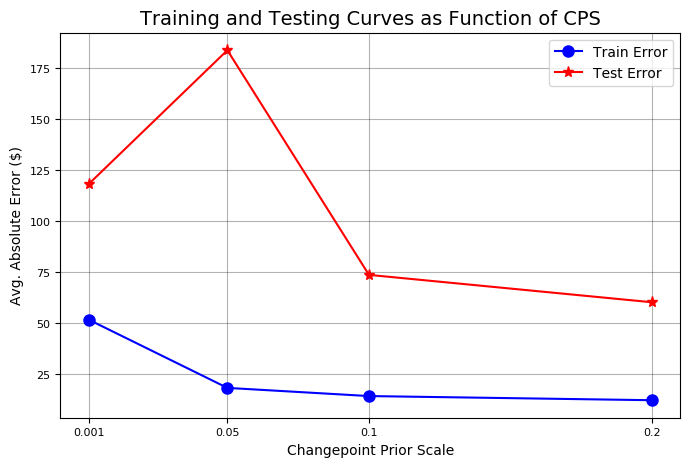

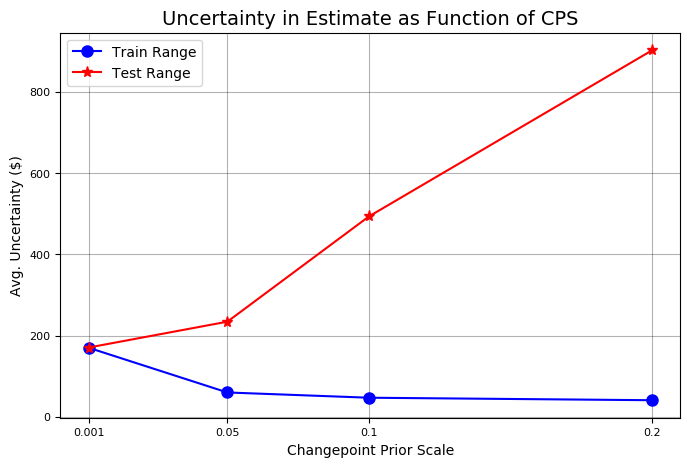

In [31]:
amazon.changepoint_prior_validation()

### Refine Search 

   cps  train_err  train_range   test_err   test_range
0  0.2  12.161028    40.699850  60.210005   893.983153
1  0.3  10.782652    36.728515  87.404968  1251.030349
2  0.4  10.342196    35.493587  96.710767  1454.341269
3  0.5  10.209218    35.044201  99.988787  1554.822497


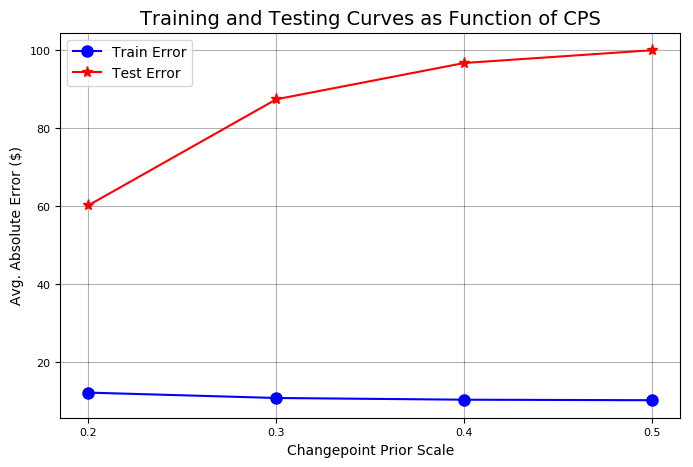

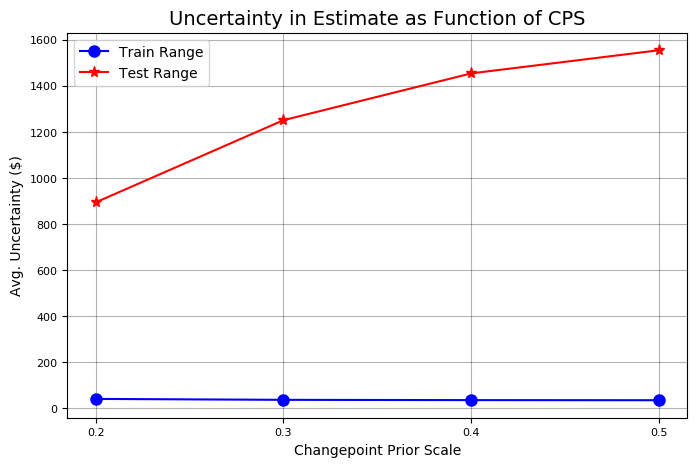

In [32]:
amazon.changepoint_prior_validation(changepoint_priors=[0.2, 0.3, 0.4, 0.5])

We now assign the changepoint prior with the smallest error on the testing set to the Stocker object. The prior is one of the attiributes and we can change it like any other variable. 

In [33]:
amazon.changepoint_prior_scale = 0.2

# Evaluate Predictions


Prediction Range: 2017-01-18 to 2018-01-18.

Predicted price on 2018-01-17 = $1062.47.
Actual price on    2018-01-17 = $1295.00.

Average Absolute Error on Training Data = $12.16.
Average Absolute Error on Testing  Data = $60.21.

When the model predicted an increase, the price increased 58.02% of the time.
When the model predicted a  decrease, the price decreased  45.98% of the time.

The actual value was within the 80% confidence interval 91.20% of the time.


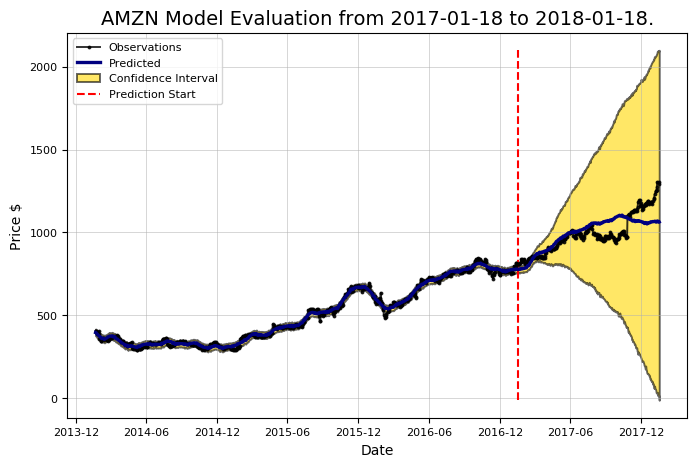

In [34]:
amazon.evaluate_prediction()

You played the stock market in AMZN from 2017-01-18 to 2018-01-18 with 1000 shares.

When the model predicted an increase, the price increased 58.02% of the time.
When the model predicted a  decrease, the price decreased  45.98% of the time.

The total profit using the Prophet model = $335790.00.
The Buy and Hold strategy profit =         $487520.00.

Thanks for playing the stock market!



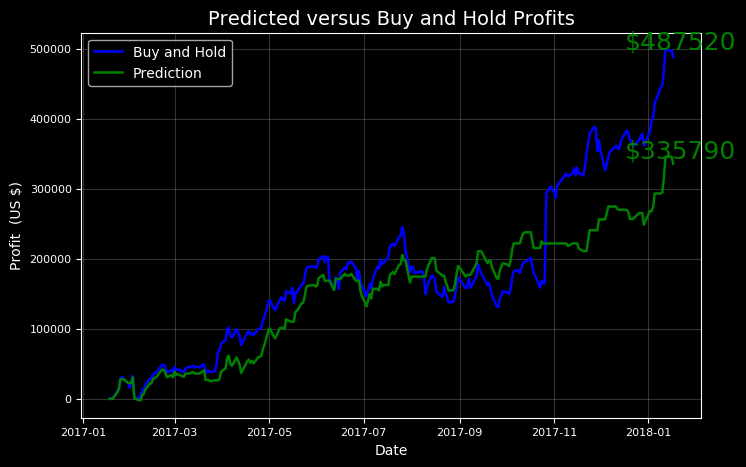

In [35]:
amazon.evaluate_prediction(nshares=1000)

# Predict the Future

As a last step, we can predict any number of days into the future. This function automatically trains on the past 3 years and makes predictions with the uncertainty intervals. 


Predicted Increase: 

         Date     estimate    change        upper        lower
1  2018-01-19  1286.499035  3.389335  1306.037129  1267.112248
3  2018-01-21  1290.863389  4.364354  1309.601786  1269.454376
4  2018-01-22  1295.085302  4.221914  1316.379580  1275.840441
5  2018-01-23  1300.633984  5.548681  1320.549521  1280.832648
6  2018-01-24  1305.635325  5.001341  1325.455203  1286.695972
7  2018-01-25  1308.748464  3.113139  1329.805447  1288.020432
8  2018-01-26  1310.566905  1.818441  1331.159702  1290.981757
10 2018-01-28  1317.516833  6.949928  1339.233730  1299.019849

Predicted Decrease: 

Empty DataFrame
Columns: [Date, estimate, change, upper, lower]
Index: []


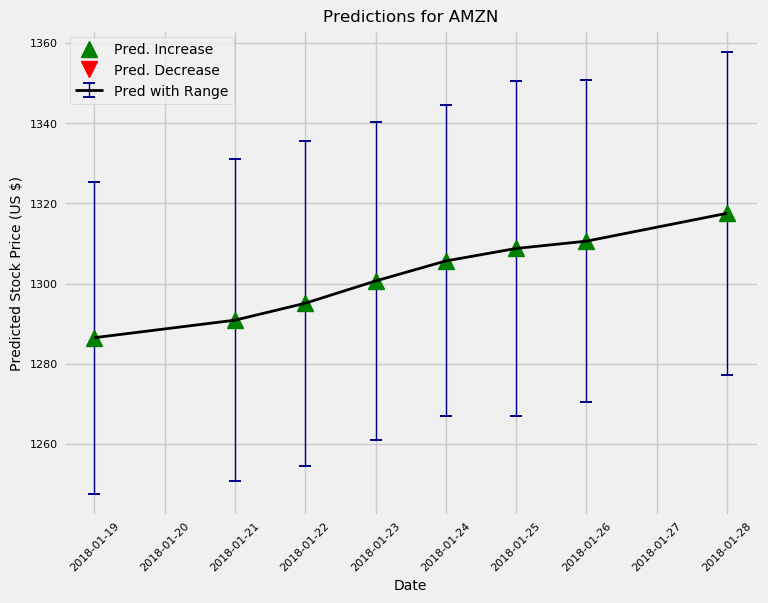

In [36]:
amazon.predict_future(days=10)


Predicted Increase: 

         Date     estimate    change        upper        lower
1  2018-01-19  1286.499035  3.389335  1306.089217  1266.361941
3  2018-01-21  1290.863389  4.364354  1309.273815  1269.433057
4  2018-01-22  1295.085302  4.221914  1314.483957  1275.282916
5  2018-01-23  1300.633984  5.548681  1320.864821  1281.041302
6  2018-01-24  1305.635325  5.001341  1324.115466  1285.560808
7  2018-01-25  1308.748464  3.113139  1329.358538  1289.412089
8  2018-01-26  1310.566905  1.818441  1329.949397  1291.408557
10 2018-01-28  1317.516833  6.949928  1338.358411  1297.554433
11 2018-01-29  1323.074347  5.557514  1344.953479  1303.776572
12 2018-01-30  1327.260582  4.186235  1350.218432  1306.693457
13 2018-01-31  1328.253574  0.992992  1349.455584  1308.980763
17 2018-02-04  1330.403693  5.138617  1353.073941  1308.369512
18 2018-02-05  1334.861143  4.457450  1358.234333  1311.402799
19 2018-02-06  1337.383367  2.522223  1361.487845  1313.281175
20 2018-02-07  1337.519342  0.13

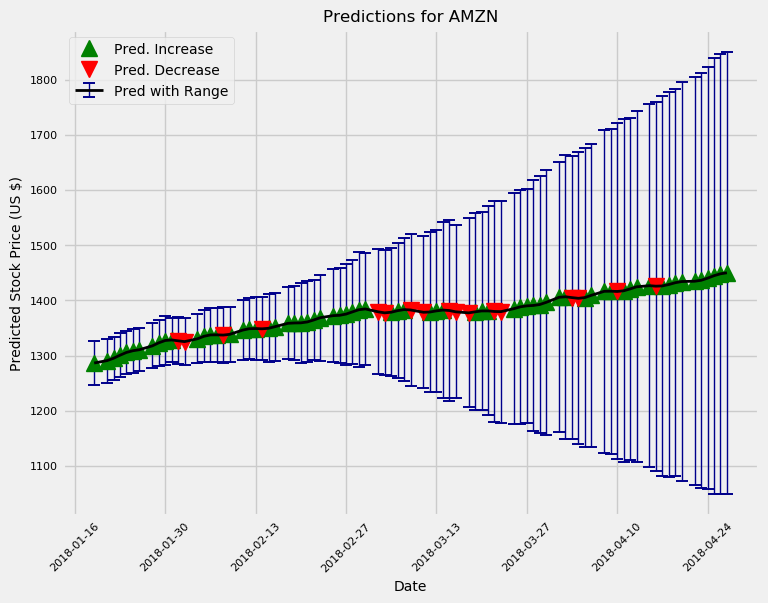

In [37]:
amazon.predict_future(days=100)

The uncertainty increases the farther out in the future we predict. This is to be expected because the initial forecasts have some uncertainty, and the next forecasts are made on the previous ones, so the range of possible values grows over time. 

Whenever we make a prediction, we must be sure to include uncertainty intervals because there are no processes that can be exactly estimated in the future. While most people interpret a confidence interval as a lack of confidence, it really displays that we know the limitations of our model. 

In [ ]:
amazon.changepoint_prior_analysis(changepoint_priors=[0.001, 0.05, 0.1, 0.8])